### Coding the generative network
* **Dense:** it’s the noise layer of our generator.

*  **Conv2DTranspose:** this enables to convolve backwards, that is, to  upscale and convolve the image at the same time. It is the equivalent of using the function UpSampling2D followed by Conv2D. <br>
* **LeakyReLU:** it is better than the ReLU functions, because it avoids gradient vanish. <br>
* **BatchNormalization:** it enables to normalize the result of a convolution. <br>
* **Reshape:** this enables us to transform a one-dimensional vector into a three-dimensional array.

In [1]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential

In [2]:
def generador_de_imagenes():

    generador = Sequential()

    generador.add(Dense(256*4*4, input_shape = (100,)))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU())
    generador.add(Reshape((4,4,256)))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))


    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2D(3,kernel_size=3, padding = "same", activation='tanh'))

    return(generador)

modelo_generador = generador_de_imagenes()

modelo_generador.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         295040    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0

### **Checking if the generative network works**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


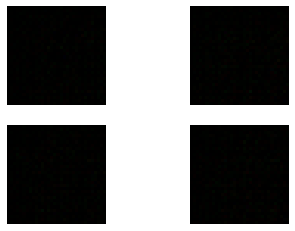

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Definir datos de entrada
def generar_datos_entrada(n_muestras):
  X = np.random.randn(100 * n_muestras)
  X = X.reshape(n_muestras, 100)
  return X

def crear_datos_fake(modelo_generador, n_muestras):
  input = generar_datos_entrada(n_muestras)
  X = modelo_generador.predict(input)
  y = np.zeros((n_muestras, 1))
  return X,y

numero_muestras = 4
X,_ = crear_datos_fake(modelo_generador, numero_muestras)

# Visualizamos resultados
for i in range(numero_muestras):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])

### **Structure of the discriminator network**

In [5]:
from keras.layers import Conv2D, Flatten, Dropout
from keras.optimizers import Adam

def discriminador_de_imagenes():

    discriminador = Sequential()
    discriminador.add(Conv2D(64, kernel_size=3, padding = "same", input_shape = (32,32,3)))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(256, kernel_size=3, strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Flatten())
    discriminador.add(Dropout(0.4))
    discriminador.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.0002 ,beta_1=0.5)
    discriminador.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminador)

modelo_discriminador = discriminador_de_imagenes()
modelo_discriminador.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 256)        

### **Load data from Cifar10**
we will normalize the data. This will make the model work faster. To do so, as an RGB layer goes from 0 to 255, we will subtract and then divide 127.5. By doing so, values will go from -1 to 1.

In [6]:
from keras.datasets import cifar10

def cargar_imagenes():
    (Xtrain, Ytrain), (_, _) = cifar10.load_data()

    # Nos quedamos con los perros
    indice = np.where(Ytrain == 0)
    indice = indice[0]
    Xtrain = Xtrain[indice, :,:,:]

    # Normalizamos los datos
    X = Xtrain.astype('float32')
    X = (X - 127.5) / 127.5

    return X

print(cargar_imagenes().shape)

170508288/170498071 [==============================] - 6s 0us/step
(5000, 32, 32, 3)


### **Training the discriminator network**
we have to train our discriminator network. To do so, we will need both real and fake images, so we will create a function that generates exactly that.

In order to create fake images, it is important to create images that have the same shape as real images. As we have seen before, real images are arrays of 32x32x3, so we will need to create n images with this shape.

In [7]:
import random

def cargar_datos_reales(dataset, n_muestras):
  ix = np.random.randint(0, dataset.shape[0], n_muestras)
  X = dataset[ix]
  y = np.ones((n_muestras, 1))
  return X,y

def cargar_datos_fake(n_muestras):
  X = np.random.rand(32 * 32 * 3 * n_muestras)
  X = -1 + X * 2
  X = X.reshape((n_muestras, 32,32,3))
  y = np.zeros((n_muestras, 1))
  return X,y

def entrenar_discriminador(modelo, dataset, n_iteraciones=20, batch = 128):
  medio_batch = int(batch/2)

  for i in range(n_iteraciones):
    X_real, y_real = cargar_datos_reales(dataset, medio_batch)
    _, acc_real = modelo.train_on_batch(X_real, y_real)

    X_fake, y_fake = cargar_datos_fake(medio_batch)
    _, acc_fake = modelo.train_on_batch(X_fake, y_fake)

    print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))

dataset = cargar_imagenes()
entrenar_discriminador(modelo_discriminador, dataset)

1 Real:75.0, Fake:1.5625
2 Real:98.4375, Fake:4.6875
3 Real:93.75, Fake:32.8125
4 Real:95.3125, Fake:68.75
5 Real:95.3125, Fake:98.4375
6 Real:90.625, Fake:100.0
7 Real:90.625, Fake:100.0
8 Real:90.625, Fake:100.0
9 Real:85.9375, Fake:100.0
10 Real:90.625, Fake:100.0
11 Real:92.1875, Fake:100.0
12 Real:89.0625, Fake:100.0
13 Real:95.3125, Fake:100.0
14 Real:98.4375, Fake:100.0
15 Real:100.0, Fake:100.0
16 Real:98.4375, Fake:100.0
17 Real:100.0, Fake:100.0
18 Real:98.4375, Fake:100.0
19 Real:100.0, Fake:100.0
20 Real:98.4375, Fake:100.0


### generative adversarial network

In [9]:
def crear_gan(discriminador, generador):
    discriminador.trainable=False
    gan = Sequential()
    gan.add(generador)
    gan.add(discriminador)

    opt = Adam(learning_rate=0.0002,beta_1=0.5) 
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan

gan = crear_gan(modelo_discriminador,modelo_generador)
gan.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         1007363   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 522497    
Total params: 1,529,860
Trainable params: 1,007,363
Non-trainable params: 522,497
_________________________________________________________________


### **Model evaluation and image generation functions**

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

def mostrar_imagenes_generadas(datos_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  # Hacemos que los datos vayan de 0 a 1
  datos_fake = (datos_fake + 1) / 2.0

  for i in range(10):
    plt.imshow(datos_fake[i])
    plt.axis('off')
    nombre = str(epoch) + '_imagen_generada_' + str(i) + '.png'
    plt.savefig(nombre, bbox_inches='tight')
    plt.close()

In [11]:
def evaluar_y_guardar(modelo_generador, epoch, medio_dataset):

  # We save the model
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  nombre = str(epoch) + '_' + str(now)+"_modelo_generador_" + '.h5'
  modelo_generador.save(nombre)

  # We generate new data
  X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)
  X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

  # We evaluate the model
  _, acc_real = modelo_discriminador.evaluate(X_real, Y_real)
  _, acc_fake = modelo_discriminador.evaluate(X_fake, Y_fake)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

In [12]:
def entrenamiento(datos, modelo_generador, modelo_discriminador, epochs, n_batch, inicio = 0):
  dimension_batch = int(datos.shape[0]/n_batch)
  medio_dataset = int(n_batch/2)

  # We iterate over the epochs
  for epoch in range(inicio, inicio + epochs):
    # We iterate over all batches
    for batch in range(n_batch):

      # We load all the real data
      X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)


      # We train the discriminator withEnrenamos discriminador con datos reales
      coste_discriminador_real, _ = modelo_discriminador.train_on_batch(X_real, Y_real)
      X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

      coste_discriminador_fake, _ = modelo_discriminador.train_on_batch(X_fake, Y_fake)

      # We generate input images for the GAN
      X_gan = generar_datos_entrada(medio_dataset)
      Y_gan = np.ones((medio_dataset, 1))

      # We train the GAN with fake data
      coste_gan = gan.train_on_batch(X_gan, Y_gan)

    # Every 10 epochs we show the results and cost 
    if (epoch+1) % 10 == 0:
      evaluar_y_guardar(modelo_generador,epoch = epoch, medio_dataset= medio_dataset)
      mostrar_imagenes_generadas(X_fake, epoch = epoch)

In [ ]:
entrenamiento(dataset, modelo_generador, modelo_discriminador, epochs = 100, n_batch=128, inicio = 0)

2/2 [==============================] - 0s 38ms/step - loss: 0.4015 - accuracy: 0.8750
Acc Real:71.875% Acc Fake:87.5%
2/2 [==============================] - 0s 38ms/step - loss: 0.5224 - accuracy: 0.8438
Acc Real:71.875% Acc Fake:84.375%
